**Importing packages that we need**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, vectorize, prange
import numba as numba
import time

## Here are the functions needed for the Monte Carlo calculations and Metropolis algorithm:

In [3]:
#function that defines that inital state for the lattice calling a random number generator
@jit(nopython=True)
def StateInitalize(N):
    #NXN number of spins
    Lattice = np.zeros((N,N))
    for i in range(N):
        for l in range(N):
            randNum = np.random.random()
            if randNum < 0.5:
                Lattice[i,l] = int(-1)
            else:
                Lattice[i,l] = int(1)
                
    return Lattice

In [4]:
#function that defines that inital state either all spins up or down
@jit()
def StateInitalizeNonRandom(N,position):
    #NXN number of spins
    if position == "up":
        temp = int(1)
    else:
        temp = int(-1)
    Lattice = np.zeros((N,N))
    for i in range(N):
        for l in range(N):
            Lattice[i,l] = temp
            randNum = np.random.random()
                
    return Lattice

**NeigbourInteraction is a function that calculates the change in energy upon flipping one spin:**

In [5]:
@jit()
def NeigbourInteraction(line,column,InitialState,LatticeSize):
    M = LatticeSize
    DeltaE = 0
    if line == int(0):#if at the top edge of lattice
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,M-1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,0]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[M-1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line+1,column]#below
    if line == int((M-1)):#if at the bottom edge lattice
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,M-1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,0]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line-1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[0,column]#below
    #Then check if at left or right edges or inside
    else:
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,M-1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,0]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line+1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line-1,column]#below

    DeltaE = -(Temp1 + Temp2 + Temp3 + Temp4)
    DeltaE = DeltaE*2
    if DeltaE not in [-8,-4,0,4,8]:
        print("The change in energy is not right")
    return int(DeltaE)

**Function that calculates the Magnetization:**

In [6]:
@jit(nopython=True)
def Magnetization(Lattice):
    N,M = np.shape(Lattice)
    Magnetization = 0
    for i in range(M):#looping over lines
        for j in range(M):#looping over colums
            Magnetization += Lattice[i,j]#Adding the spin value at location i,j
    #Calculating the absolute value of Magnetization
    AbsoluteMagnetization = np.absolute(Magnetization)
    
    return Magnetization, AbsoluteMagnetization

In [7]:
#Trial of Magnetization function
LatticeA = np.array([[1,-1],[-1,-1]])
Magn, AbsMagn = Magnetization(LatticeA)
print("The Magnetization is:",Magn)
print("The Absolute Magnetization is:",AbsMagn)

The Magnetization is: -2
The Absolute Magnetization is: 2


**Calculating the energy of the lattice according to the Ising model with periodic boundary conditions:**

In [8]:
@jit()
def LatticeEnergyIsing(InitialState,LatticeSize):
    N,M = np.shape(InitialState)#Lattice size
    Energy = 0
    for i in range(M):#loop over lines
        for j in range(M):#loop over columns
            #Only checking every other site so that one doesn't double count
            DoMeasurement = (np.mod(i,2)+np.mod(j,2) == 0) or (np.mod(i,2)+np.mod(j,2) == 2)
            #print(Acceptance)
            if DoMeasurement:
                if (i == 0 and j == 0):#if at the top and left edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,M-1]#to the left - periodic boundary
                    Temp3 = InitialState[i,j]*InitialState[M-1,j]#above - periodic boundary
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == 0 and j == (M-1)):#if at the top and right edge of lattice
                    #Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    #Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp2 + Temp4)
                elif (i == (M-1) and j == 0):#if at the bottom and left edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    #Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    #Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp3)
                elif (i == (M-1) and j == (M-1)):#if at the bottom and right edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,0]#to the right - periodic boundary
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[0,j]#below - periodic boundary
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif i == 0:#if only at top edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[M-1,j]#above - periodic boundary
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif i == (M-1):#if only at bottom edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    #Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3)
                elif j == 0:#if only at left edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,M-1]#to the left - periodic boundary
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif j == (M-1):#if only at right edge
                    #Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp2 + Temp3 + Temp4)
                else:#if somewhere in the middle
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
            elif M > 2 and (np.mod(M,2) != 0):#To not double count for 2x2 lattice - odd case M
                if i == 0:#If at the top and at odd site
                    Temp1 = InitialState[i,j]*InitialState[M-1,j-1]#above - periodic boundary
                    Energy += -(Temp1)
                elif j == 0:#At the right edge and odd site
                    Temp1 = InitialState[i,j]*InitialState[i,M-1]
                    Energy += -(Temp1)
                else:
                    continue
            TruthValue = ((np.mod(i,2) == 0) and (j == (M-1)))
            TruthValue = TruthValue and np.mod(M,2) == 0
            #print(TruthValue,i,j)
            #Even case, count the rest that hasn't been counted
            if M > 2 and TruthValue:
                if i == 0:
                    Temp1 = InitialState[i,j]*InitialState[i,M-1]#above - periodic boundary
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#above - periodic boundary
                    #Energy += -(Temp1 + Temp2)
                elif i == (M-1):
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#above - periodic boundary
                    Temp2 = InitialState[i,j]*InitialState[i,0]#above - periodic boundary
                    Energy += -(Temp1 + Temp2)
                else:
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#above - periodic boundary
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#above - periodic boundary
                    Energy += -(Temp1 + Temp2)
    return Energy

In [10]:
#Trial of energy
B = np.array([[-1,-1],[-1,-1]])
print(B)
EnergyTrial = LatticeEnergyIsing(B,2)
print("The energy according to Ising Model:", EnergyTrial)
L = 60
TrialLatticeUp = StateInitalizeNonRandom(L,"up")
EnergyTrial2 = LatticeEnergyIsing(TrialLatticeUp,L)
print("For all spins up the energy is:", EnergyTrial2)
print(EnergyTrial2/(L*L))
#Trial of change in energy
DeltaE = NeigbourInteraction(0,0,B,2)
print("The change in energy upon flipping spin at [0,0]",DeltaE)
TrialLatticeUp = StateInitalize(4)
print(TrialLatticeUp)
DeltaE = NeigbourInteraction(1,1,TrialLatticeUp,4)
print("The change in energy upon flipping spin at [1,1]",DeltaE)

[[-1 -1]
 [-1 -1]]
The energy according to Ising Model: -8
For all spins up the energy is: -7200.0
-2.0
The change in energy upon flipping spin at [0,0] -8
[[-1.  1. -1. -1.]
 [ 1. -1.  1. -1.]
 [ 1.  1. -1. -1.]
 [-1.  1.  1.  1.]]
The change in energy upon flipping spin at [1,1] 8


**Function that counts how often a certain element is found in an array:**

In [11]:
def ArrayElementCounter(array):
    energylist = []
    energylist.append(array[0])
    for i in range(1,len(array)):
        if array[i] not in energylist:
            energylist.append(array[i])
            
    energylist.sort()
    countinglist = np.zeros(len(energylist))
    for i in range(len(array)):
        temp = array[i]
        position = np.where(energylist == temp)
        countinglist[position[0][0]] += 1
            
    return energylist, countinglist

In [12]:
#Trial
Vigur = np.array([0,3,4,4,6,8,7,7])
energylist,countinglist = ArrayElementCounter(Vigur)
print(energylist,countinglist)

[0, 3, 4, 6, 7, 8] [1. 1. 2. 1. 2. 1.]


**Metropolis part: This is the function that takes care of the Metropolis algorithm**

In [90]:
@jit()
def Metropolis(DeltaEnergy,Exponent,Temperature):
    if DeltaEnergy not in [-8,-4,0,4,8]:
        print("The change in Energy does not agree with the Ising model")
    Accept = False
    if DeltaEnergy <= 0:
        Accept = True
    else:
        randNum = np.random.random()
        w = Exponent
        #Checking w agains the exponent and accepting if r <= w
        if randNum <= w:
            Accept = True
        else:
            Accept = False
            
    return Accept

**The Monte Carlo calculation itself: Everything combines into the MonteCarloIsing function**

In [91]:
@jit(nopython=True)
def MonteCarloIsing(InitialState,NumOfCycles,LatticeSize,Temperature,SkipCycles):
    EnergyVector = np.zeros(NumOfCycles)
    MagnetizationVector = np.zeros(NumOfCycles)
    MagnetizationVectorAbs = np.zeros(NumOfCycles)
    M = LatticeSize
    NSpins = M*M#Number of spins
    #Calculating the initial energy
    Energy = LatticeEnergyIsing(InitialState,M)
    #print(Energy)
    MC = NumOfCycles
    CounterAcceptance = 0#Counter to see how many moves are accepted
    EnergyValue = 0#Value to assign the energy when we start to take measurements
    EnergyValueSquared = 0#Value to assign the energy^2 when we start to take measurements
    MagnValue = 0#Value to assign the Magnitization when we start to take measurements
    MagnValueSquared = 0#Value to assign the Magnitization^2 when we start to take measurements
    MagnValueAbs = 0#Value to assign the Absolute Magnetzation when we start to take measurements
    norm = 1/MC
    T = Temperature
    counter = 0
    #precalculation of exponents
    Exp1 = np.exp(-(1/Temperature)*(-8))
    Exp2 = np.exp(-(1/Temperature)*(-4))
    Exp3 = 1
    Exp4 = np.exp(-(1/Temperature)*(4))
    Exp5 = np.exp(-(1/Temperature)*(8))
    for i in range(MC):#Looping over the number of MC cycles
        #loop over number of spins
        for k in range(NSpins):
            #picking a random coordinate in the lattice
            line = np.random.randint(M)
            column = np.random.randint(M)
            #flipping the spin at that position
            TempState = InitialState.copy()#Taking a copy so we don't change the initial state
            #Then we check the value at that position
            if InitialState[line,column] == 1:
                TempState[line,column] = int(-1)
                tempValue = int(-1)#setting temp value to the assign to the system if move is accepted
            else:
                TempState[line,column] = int(1)
                tempValue = int(1)#setting temp value to the assign to the system if move is accepted
            #finding the difference in energy - using periodic boundary conditions
            DeltaE = NeigbourInteraction(line,column,TempState,M)
            if DeltaE == -8:
                Exp = Exp1
            elif DeltaE == -4:
                Exp = Exp2
            elif DeltaE == 0:
                Exp = Exp3
            elif DeltaE == 4:
                Exp = Exp4
            else:
                Exp = Exp5
            #Metropolis part
            Acceptance = Metropolis(DeltaE,Exp,T)
            if Acceptance:
                InitialState[line,column] = tempValue#Change the spin at the location if move accepted
                Energy = LatticeEnergyIsing(InitialState,M)#Calculate the new energy value
                CounterAcceptance += 1#count if the step was accepted  
        #Appending Energy and other relevant variables for calculations
        EnergyVector[counter] = Energy
        MagnetiZ, MagnetiZAbs = Magnetization(InitialState)
        MagnetizationVector[counter] = MagnetiZ
        MagnetizationVectorAbs[counter] = MagnetiZAbs
        counter += 1
        if i >= SkipCycles:#Accounting for time that it takes to reach the most likely state
            if not Acceptance:
                if EnergyVector[counter-1] != Energy:
                    print("Error Error Error")
                    print(EnergyVector[counter-1],Energy)
            EnergyValue += Energy
            EnergyValueSquared += Energy**2
            #Magnetization
            MagnValue += MagnetiZ
            MagnValueSquared += MagnetiZ**2
            MagnValueAbs += MagnetiZAbs
            
        #End of MC loop

    MCUsed = MC - SkipCycles#Accounting for the number of cycles that were skipped
    #Calculating average energy per particle
    #TotalEnergy = sum(EnergyVector)
    AverageEnergy = EnergyValue/MCUsed
    AverageEnergySquared = EnergyValueSquared/MCUsed
    #Energy per spin
    EnergyPerParticle = AverageEnergy/NSpins
    #Variance in Energy
    EnergyVariancePerSpin = (AverageEnergySquared - AverageEnergy**2)/NSpins
    #Specific Heat - SPURNING hvað ég að nota fyrir Boltzmanns fasta
    k = 1
    SpecificHeat = (1/(k*(T**2)))*EnergyVariancePerSpin
    #Magnetization
    AverageMagnetization = MagnValue/MCUsed
    AverageMagnetizationPerPar = AverageMagnetization/NSpins
    AverageMagnetizationSquared = MagnValueSquared/MCUsed
    AverageMagnetizationAbs = MagnValueAbs/MCUsed
    AverageMagnetizationAbsPerSpin = AverageMagnetizationAbs/NSpins
    #Variance in Magnetization
    MagnetizationVariancePerSpin = (AverageMagnetizationSquared - AverageMagnetizationAbs**2)/(NSpins)
    #Susceptibility
    Susceptibility = (1/(k*T))*MagnetizationVariancePerSpin

    return CounterAcceptance, EnergyVector, MagnetizationVector, MagnetizationVectorAbs, EnergyPerParticle, AverageMagnetizationPerPar, AverageMagnetizationAbsPerSpin, SpecificHeat, Susceptibility

**Trying the algo for a 2x2 case:**

In [93]:
L = 2
MCCycles = int(5e5)
SkipCycles = 0
A = StateInitalize(L)
TempSmall = np.arange(0.1,5.1,0.4)
EnergySmallCase = np.zeros(len(TempSmall))
SpecHeatSmallCase = np.zeros(len(TempSmall))
MeanMagnAbsSmallCase = np.zeros(len(TempSmall))
SusceptibilitySmallCase = np.zeros(len(TempSmall))
start = time.time()
counter = 0
for T1 in TempSmall:
    AcceptedMoves, EnergyAll, MagnAll, MagnAllAbs,EnergyPerPart, AverageMagn, AverageMagnAbs, SpecificHeat, Susceptibility = MonteCarloIsing(A,MCCycles,L,T1,SkipCycles)
    EnergySmallCase[counter] = EnergyPerPart
    SpecHeatSmallCase[counter] = SpecificHeat
    MeanMagnAbsSmallCase[counter] = AverageMagnAbs
    SusceptibilitySmallCase[counter] = Susceptibility
    counter += 1
    
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMoves)
print("Energy per particle:",EnergyPerPart)
print("The Average magnetization per spin is:",AverageMagn)
print("The Average absolute magnetization per spin is",AverageMagnAbs)
print("The Specific Heat is:",SpecificHeat)
print("The Susceptibility is:",Susceptibility)

The measurement took, in seconds: 5.296939134597778
Number of Accepted moves: 1129919
Energy per particle: -0.86932
The Average magnetization per spin is: -0.0028
The Average absolute magnetization per spin is 0.629258
The Specific Heat is: 0.18696655353602665
The Susceptibility is: 0.11812438321306126


## Analytical results for 2x2 case:

**We now look at analytical results for a 2x2 case of spins:**

In [16]:
#All the relevant functions for the 2x2 case
def EnergyExp(T):
    Beta = 1/T
    temp = -((8*np.sinh(8*Beta))/(np.cosh(8*Beta) + 3))
    return temp/4

def Z(T):
    Beta = 1/T
    return 2*np.exp(8*Beta) + 12 + 2*np.exp(-8*Beta)

def SpecificHeatSmall(T):##Eitthvað vitlaust hér eða hvað??
    Beta = 1/T
    teljari = 64*(1 + 3*np.cosh(8*Beta))
    nefnari = (T**2)*((np.cosh(8*Beta) + 3)**2)
    return teljari/nefnari/4

def AveragAbsMagnSmall(T):
    Beta = 1/T
    temp = (8*np.exp(8*Beta) + 16)/Z(T)
    return temp/4

def SusceptibilitySmall(T):
    Beta = 1/T
    firstTerm = (32/Z(T))*(1 + np.exp(8*Beta))
    secondTerm = (64/Z(T)**2)*((2 + np.exp(8*Beta)))**2
    return Beta*(firstTerm - secondTerm)/4

**Let's plot:**

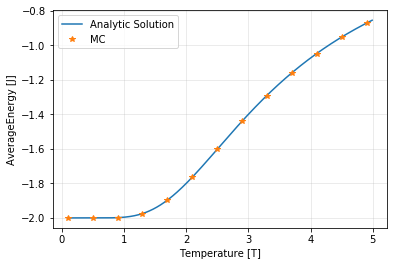

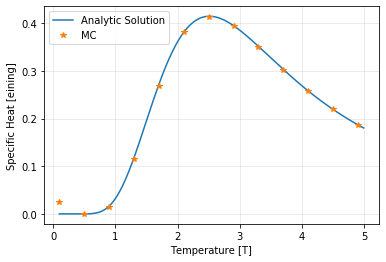

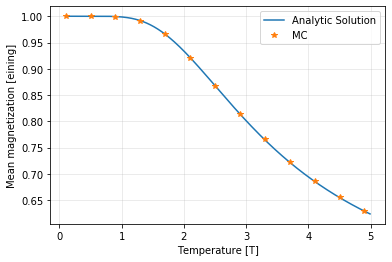

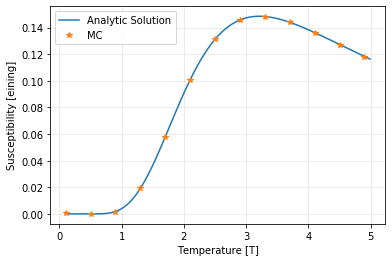

In [94]:
fig0,ax0 = plt.subplots()
T = np.arange(0.1,5,0.01)
AvergeEnergySmall = EnergyExp(T)
SpecHeatSmall = SpecificHeatSmall(T)
AverageAbsSmall = AveragAbsMagnSmall(T)
SucsSmall = SusceptibilitySmall(T)
#Average energy
ax0.plot(T,AvergeEnergySmall,label="Analytic Solution")
ax0.plot(TempSmall,EnergySmallCase,'*',label="MC")
ax0.grid(alpha=0.3)
ax0.set_ylabel("AverageEnergy [J]")
ax0.set_xlabel("Temperature [T]")
ax0.legend()
#Specific Heat
fig0_1,ax0_1 = plt.subplots()
ax0_1.plot(T,SpecHeatSmall,label="Analytic Solution")
ax0_1.plot(TempSmall,SpecHeatSmallCase,'*',label="MC")
ax0_1.grid(alpha=0.3)
ax0_1.set_ylabel("Specific Heat [eining]")
ax0_1.set_xlabel("Temperature [T]")
ax0_1.legend()
#Mean magnetization - Skrýtið gildi fyrir analytical!!
fig0_2,ax0_2 = plt.subplots()
ax0_2.plot(T,AverageAbsSmall,label="Analytic Solution")
ax0_2.plot(TempSmall,MeanMagnAbsSmallCase,'*',label="MC")
ax0_2.grid(alpha=0.3)
ax0_2.set_ylabel("Mean magnetization [eining]")
ax0_2.set_xlabel("Temperature [T]")
ax0_2.legend()
#Susceptibility - Per spin!
fig0_3,ax0_3 = plt.subplots()
ax0_3.plot(T,SucsSmall,label="Analytic Solution")
ax0_3.plot(TempSmall,SusceptibilitySmallCase,'*',label="MC")
ax0_3.grid(alpha=0.3)
ax0_3.set_ylabel("Susceptibility [eining]")
ax0_3.set_xlabel("Temperature [T]")
ax0_3.legend()

## Parallelized Monte Carlo:

**We now parallize our code (for different temperatures)**

In [108]:
@jit(nopython=True,parallel=True)
def MonteCarloIsingParallel2(State,NumOfCycles,L,Temperature,Time,SkipCycles):
    #Calling the original MCIsing with Temperature Parallized
    T = Temperature
    CounterAccept = np.zeros(len(T))
    EnergyPerPart = np.zeros(len(T))
    AverageMagnPerPart = np.zeros(len(T))
    AverageMagnPerPartAbs = np.zeros(len(T))
    SpecificHeat = np.zeros(len(T))
    Susceptibility = np.zeros(len(T))
    AllEnergyPerPart = np.zeros((len(T),NumOfCycles))
    AllAbsMagnPerPart = np.zeros((len(T),NumOfCycles))
    TempSkip = SkipCycles
    for i in prange(len(T)):
        np.random.seed(Time*(i+1))#Seeding differently for each thread if they start at the same time
        #Calling the original MC Ising
        TempState = State.copy()
        CountAcc, EnergyVec, AvMagnVec, AvMagnAbsVec, EnPerPa, AvMagnPePa, AvMagnPePaAbs, SpeHeat, Susc = MonteCarloIsing(TempState,NumOfCycles,L,T[i],TempSkip)
        CounterAccept[i] = CountAcc
        EnergyPerPart[i] = EnPerPa
        AverageMagnPerPart[i] = AvMagnPePa
        AverageMagnPerPartAbs[i] = AvMagnPePaAbs
        SpecificHeat[i] = SpeHeat
        Susceptibility[i] = Susc
        AllEnergyPerPart[i,:] = EnergyVec
        AllAbsMagnPerPart[i,:] = AvMagnAbsVec
        
        
    return CounterAccept, EnergyPerPart, AverageMagnPerPart, AverageMagnPerPartAbs, SpecificHeat, Susceptibility, AllEnergyPerPart, AllAbsMagnPerPart

**Writing to file:**

In [248]:
def WriteToFile(filename,NumOfCycles,SkipCycles,L,EnergyPerPart,SpecificHeat,AverageMagnPerPartAbs,Susceptibility,CounterAccept,T,time,EnergyAll,MagnAll):
    #writing the the relevant quantities to file
    f = open(filename,"w+")
    f.write("Number of Monte Carlo Cycles: \t" + str(int(NumOfCycles)) + "\n")
    f.write("Number of MC cycles skipped before measurements: \t" + str(int(SkipCycles)) + "\n" )
    f.write("Lattice size, L = \t" + str(int(L)) + "\n")
    f.write("Number of different Temperature Measurements: \t" + str(int(len(T))) + "\n")
    f.write("The measurement took  in seconds:\t" + str(time) + "\n")
    f.write("Temperature \t EnergyPerParticle \t Heat Capacity Per Part \t Absolute Mean Magnetization \t Susceptibility \t No of accepted steps \n")
    #writing all averages in the file
    for i in range(len(T)):
        f.write(str(T[i]) + "\t" + str(EnergyPerPart[i]) + "\t" + str(SpecificHeat[i]) + "\t" + str(AverageMagnPerPartAbs[i]) + "\t" + str(Susceptibility[i]) + "\t" + str(CounterAccept[i]) + "\n")
    #writing the values for each step for further analysis
    f.write("\n \n")
    f.write("All measurments: \n")
    for i in range(len(T)):
        f.write("Temperature: \t" + str(T[i]) + "\n")
        for k in range(len(EnergyAll[i,:])):
            f.write(str(EnergyAll[i,k]) + "\t")
        f.write("\n")
        
    #Magnetization
    f.write("\n \n")
    f.write("Magnetization: \n")
    for i in range(len(T)):
        f.write("Temperature: \t" + str(T[i]) + "\n")
        for k in range(len(MagnAll[i,:])):
            f.write(str(MagnAll[i,k]) + "\t")
        f.write("\n")
        
    f.close()

In [98]:
f = open("TrialFile.txt","w+")
f.write("Number of Monte Carlo Cycles: \t 100000\n")
f.write("Number of MC cycles skipped before measurements: \t 10000 \n")
f.write("Lattice size, L = \t 10 \n")
f.write("Number of different Temperature Measurements:")

for i in range(10):
    f.write("Hello \n")
        
f.close()

In [109]:
#Trial of New Parallized MC
Time = time.time()
L = 2
StateP = StateInitalize(L)
TempRange = np.arange(0.2,5,0.1)
#TempRange = np.array([1])
SkipCycl = 0
MCCycles = int(1e6)
filename = "TrialWriting.txt"
print(TempRange)
start = time.time()
AcceptedMovesP, EnergyPerPartP, AverageMagnP, AverageMagnAbsP, SpecificHeatP, SusceptibilityP, AllEnergy, AllAbsMagn = MonteCarloIsingParallel2(StateP,MCCycles,L,TempRange,Time,0)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMovesP)
print("Energy per particle:",EnergyPerPartP)
print("The Average magnetization per spin is:",AverageMagnP)
print("The Average absolute magnetization per spin is",AverageMagnAbsP)
print("The Specific Heat is:",SpecificHeatP)
print("The Susceptibility is:",SusceptibilityP)

WriteToFile(filename,MCCycles,SkipCycl,L,EnergyPerPartP,SpecificHeatP,AverageMagnAbsP,SusceptibilityP,AcceptedMovesP,TempRange,end-start,AllEnergy)

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]
The measurement took, in seconds: 30.645967721939087
Number of Accepted moves: [1.800000e+01 2.000000e+00 2.000000e+00 6.000000e+00 3.800000e+01
 2.560000e+02 1.066000e+03 2.980000e+03 7.854000e+03 1.634800e+04
 3.065400e+04 5.134600e+04 7.843600e+04 1.132820e+05 1.548580e+05
 2.053840e+05 2.635380e+05 3.289120e+05 3.985600e+05 4.732140e+05
 5.524880e+05 6.284840e+05 7.138540e+05 7.936820e+05 8.788720e+05
 9.590940e+05 1.041216e+06 1.119275e+06 1.199554e+06 1.272889e+06
 1.351222e+06 1.418654e+06 1.490280e+06 1.554025e+06 1.619790e+06
 1.687160e+06 1.737364e+06 1.797672e+06 1.855158e+06 1.907524e+06
 1.954810e+06 2.006633e+06 2.050712e+06 2.095246e+06 2.140150e+06
 2.182049e+06 2.223777e+06 2.259736e+06]
Energy per particle: [-1.99999  -2.       -2.       -1.999998 -1.999982 -1.999876 -1.99948

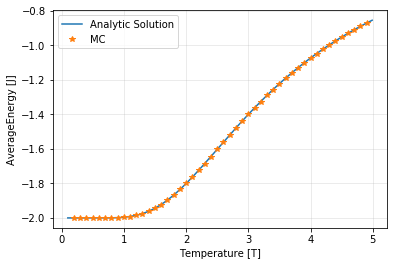

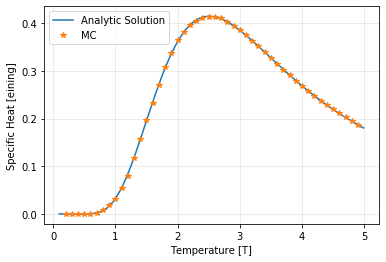

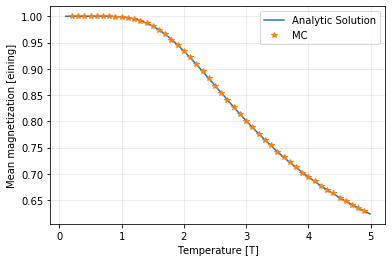

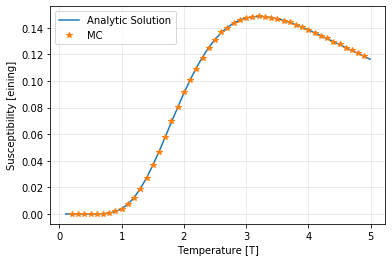

In [22]:
#Plotting the trial parallized
fig1_0,ax1_0 = plt.subplots()
T = np.arange(0.1,5,0.01)
AvergeEnergySmall = EnergyExp(T)
SpecHeatSmall = SpecificHeatSmall(T)
AverageAbsSmall = AveragAbsMagnSmall(T)
SucsSmall = SusceptibilitySmall(T)
#Average energy
ax1_0.plot(T,AvergeEnergySmall,label="Analytic Solution")
ax1_0.plot(TempRange,EnergyPerPartP,'*',label="MC")
ax1_0.grid(alpha=0.3)
ax1_0.set_ylabel("AverageEnergy [J]")
ax1_0.set_xlabel("Temperature [T]")
ax1_0.legend()
plt.savefig("L2LatticeEnergy.png",format="png",dpi=300)
#Specific Heat
fig1_1,ax1_1 = plt.subplots()
ax1_1.plot(T,SpecHeatSmall,label="Analytic Solution")
ax1_1.plot(TempRange,SpecificHeatP,'*',label="MC")
ax1_1.grid(alpha=0.3)
ax1_1.set_ylabel("Specific Heat [eining]")
ax1_1.set_xlabel("Temperature [T]")
ax1_1.legend()
plt.savefig("L2LatticeHeatCapacity.png",format="png",dpi=300)
#Mean magnetization - Skrýtið gildi fyrir analytical!!
fig1_2,ax1_2 = plt.subplots()
ax1_2.plot(T,AverageAbsSmall,label="Analytic Solution")
ax1_2.plot(TempRange,AverageMagnAbsP,'*',label="MC")
ax1_2.grid(alpha=0.3)
ax1_2.set_ylabel("Mean magnetization [eining]")
ax1_2.set_xlabel("Temperature [T]")
ax1_2.legend()
plt.savefig("L2LatticeMeanMagn.png",format="png",dpi=300)
#Susceptibility - Per spin!
fig1_3,ax1_3 = plt.subplots()
ax1_3.plot(T,SucsSmall,label="Analytic Solution")
ax1_3.plot(TempRange,SusceptibilityP,'*',label="MC")
ax1_3.grid(alpha=0.3)
ax1_3.set_ylabel("Susceptibility [eining]")
ax1_3.set_xlabel("Temperature [T]")
ax1_3.legend()
plt.savefig("L2LatticeSusceptibility.png",format="png",dpi=300)

**Trial for bigger lattice:**

In [243]:
L = 80
A2 = StateInitalize(L)
T2 = 1
SkippingCycles = int(1e4)
MCCycles = int(4e4)
start = time.time()
AcceptedMoves2, EnergyAll2, MagnAll2, MagnallAbs2, EnergyPerPart2, AverageMagn2, AverageMagnAbs2,SpecificHeat2, Susceptibility2 = MonteCarloIsing(A2,MCCycles,L,T2,SkippingCycles)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMoves2)
print("Energy per particle:",EnergyPerPart2)
print("The Average magnetization is:",AverageMagn2)
print("The Average absolute magnetization is:",AverageMagnAbs2)
print("The Specific Heat is:",SpecificHeat2)
print("The Susceptibility is:", Susceptibility2)

The measurement took, in seconds: 672.3741481304169
Number of Accepted moves: 3245213
Energy per particle: -1.9337883229166666
The Average magnetization is: 0.20988479166666668
The Average absolute magnetization is: 0.22098445833333333
The Specific Heat is: 0.05194537150207907
The Susceptibility is: 142.73200447078892


**Counting how often a certain energy value is measured:**

Text(0, 0.5, 'Counts')

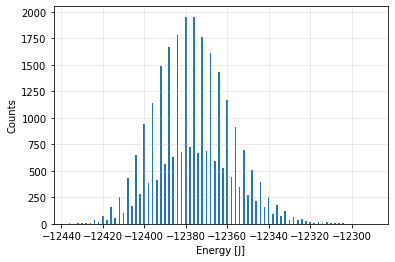

In [244]:
EnergyValue, EnergyCount = ArrayElementCounter(EnergyAll2[SkippingCycles:-1])
fig1_7,ax1_7 = plt.subplots()
ax1_7.bar(EnergyValue,EnergyCount)
ax1_7.grid(alpha=0.3)
ax1_7.set_xlabel("Energy [J]")
ax1_7.set_ylabel("Counts")
#plt.yscale("log")

In [26]:
SummaPerSpin = sum(EnergyAll2)/((MCCycles-SkippingCycles)*(L**2))
print(SummaPerSpin)
State = StateInitalizeNonRandom(3,"up")
print(LatticeEnergyIsing(State,3)/(3*3))#Gefur ekki rétta meðalorku þegar oddatala :O !!!!!

-1.645973
-2.0


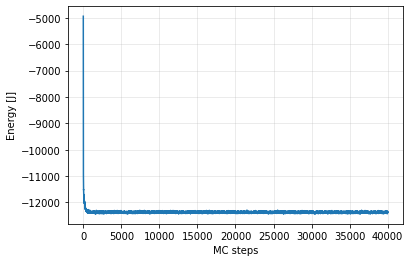

In [245]:
fig2, ax2 = plt.subplots()
Steps2 = np.arange(0,MCCycles)
ax2.plot(Steps2,EnergyAll2)
#ax2.axhline(y=-20000,c='r')
ax2.set_xlabel("MC steps")
ax2.set_ylabel("Energy [J]")
ax2.grid(alpha=0.3)
plt.savefig("EnergyMCL80.png",format="png",dpi=300)
plt.show()

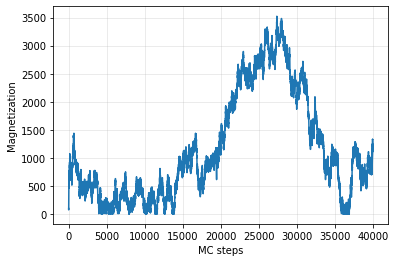

In [246]:
fig2_2, ax2_2 = plt.subplots()
Steps2 = np.arange(0,MCCycles)
#ax2_2.plot(Steps2,MagnAll2)
ax2_2.plot(Steps2,MagnallAbs2)
ax2_2.set_xlabel("MC steps")
ax2_2.set_ylabel("Magnetization")
ax2_2.grid(alpha=0.3)
plt.savefig("AbsMagnetizationL80.png",format="png",dpi=300)
plt.show()

## Analysis of lattice of size 20x20:

In [173]:
TempRange = np.array([1,2.4])
print(TempRange)
#Creating Lattice
L = 20
MCCycles20 = int(3e3)
SkipCycles20 = int(0.25e3)
State20 = StateInitalize(L)
Time20 = time.time()
start20 = time.time()
AcceptedMoves20, EnergyPerPart20, AverageMagn20, AverageMagnAbs20, SpecificHeat20, Susceptibility20, EnergyAll20, AbsMagnAll20 = MonteCarloIsingParallel2(State20,MCCycles20,L,TempRange,Time20,SkipCycles20)
end20 = time.time()
print("The measurement took, in seconds:", end20-start20)
#Non-random start point
State20Up = StateInitalizeNonRandom(L,"up")
Time20 = time.time()
start20Up = time.time()
AcceptedMoves20Up, EnergyPerPart20Up, AverageMagn20Up, AverageMagnAbs20Up, SpecificHeat20Up, Susceptibility20Up, EnergyAll20Up, AbsMagnAll20Up = MonteCarloIsingParallel2(State20Up,MCCycles20,L,TempRange,Time20,SkipCycles20)
end20Up = time.time()
print("The measurement took, in seconds:", end20Up-start20Up)

[1.  2.4]
The measurement took, in seconds: 1.4630651473999023
The measurement took, in seconds: 1.4063336849212646


**Plotting:**

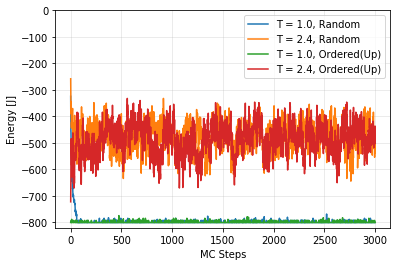

In [174]:
#Energy
figL20,axL20 = plt.subplots()
StepsL20 = np.arange(0,MCCycles20,1)
axL20.plot(StepsL20,EnergyAll20[0,:],label="T = 1.0, Random")
axL20.plot(StepsL20,EnergyAll20[1,:],label="T = 2.4, Random")
axL20.plot(StepsL20,EnergyAll20Up[0,:],label="T = 1.0, Ordered(Up)")
axL20.plot(StepsL20,EnergyAll20Up[1,:],label="T = 2.4, Ordered(Up)")
axL20.legend()
axL20.set_xlabel("MC Steps")
axL20.set_ylabel("Energy [J]")
axL20.grid(alpha=0.3)
axL20.set_ylim([-820,0])
plt.savefig("L20Comparison_4.png",format="png",dpi=300)

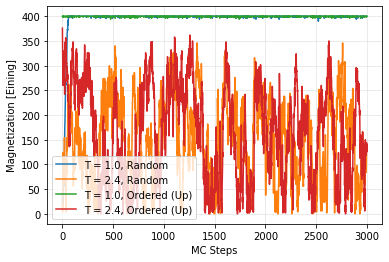

In [175]:
#Abs Magnetization
figL20,axL20 = plt.subplots()
axL20.plot(StepsL20,AbsMagnAll20[0,:],label="T = 1.0, Random")
axL20.plot(StepsL20,AbsMagnAll20[1,:],label="T = 2.4, Random")
axL20.plot(StepsL20,AbsMagnAll20Up[0,:],label="T = 1.0, Ordered (Up)")
axL20.plot(StepsL20,AbsMagnAll20Up[1,:],label="T = 2.4, Ordered (Up)")
axL20.legend()
axL20.set_xlabel("MC Steps")
axL20.set_ylabel("Magnetization [Eining]")
axL20.grid(alpha=0.3)
plt.savefig("L20Comparison_4.png",format="png",dpi=300)

**Analysing total accepted steps as function of MCCycles**

[  50  100  150  200  250  300  350  400  450  500  550  600  650  700
  750  800  850  900  950 1000 1050 1100 1150 1200 1250 1300 1350 1400
 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 2050 2100
 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650 2700 2750 2800
 2850 2900 2950]
The measurement took, in seconds: 0.04290890693664551
The measurement took, in seconds: 0.0668184757232666
The measurement took, in seconds: 0.10773515701293945
The measurement took, in seconds: 0.13830947875976562
The measurement took, in seconds: 0.1162722110748291
The measurement took, in seconds: 0.13674330711364746
The measurement took, in seconds: 0.15961527824401855
The measurement took, in seconds: 0.1708989143371582
The measurement took, in seconds: 0.22323012351989746
The measurement took, in seconds: 0.2065138816833496
The measurement took, in seconds: 0.23901772499084473
The measurement took, in seconds: 0.25212669372558594
The measurement took, in seconds: 0.31304931640625
The 

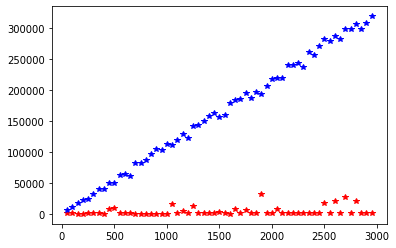

In [179]:
figL20Steps,axL20Steps = plt.subplots()
#Creating Lattice
StepsSteps = np.arange(50,3000,50)
print(StepsSteps)
for steps in StepsSteps:
    L = 20
    MCCycles20 = int(steps)
    SkipCycles20 = 0
    State20 = StateInitalize(L)
    Time20 = time.time()
    start20 = time.time()
    AcceptedMoves20, EnergyPerPart20, AverageMagn20, AverageMagnAbs20, SpecificHeat20, Susceptibility20, EnergyAll20, AbsMagnAll20 = MonteCarloIsingParallel2(State20,MCCycles20,L,TempRange,Time20,SkipCycles20)
    end20 = time.time()
    print("The measurement took, in seconds:", end20-start20)
    axL20Steps.plot(steps,AcceptedMoves20[0],'r*')
    axL20Steps.plot(steps,AcceptedMoves20[1],'b*')

**Probability distribution for 20x20 lattice:**

In [197]:
#Creating the lattice
L = 20
TempRange = np.array([1,2.4])
MCCycles20 = int(4e4)
SkipCycles20 = 1500
State20 = StateInitalize(L)
Time20 = time.time()
start20 = time.time()
AcceptedMoves20, EnergyPerPart20, AverageMagn20, AverageMagnAbs20, SpecificHeat20, Susceptibility20, EnergyAll20, AbsMagnAll20 = MonteCarloIsingParallel2(State20,MCCycles20,L,TempRange,Time20,SkipCycles20)
end20 = time.time()
print("The measurement took, in seconds:", end20-start20)

The measurement took, in seconds: 17.72989058494568


Text(0.5, 0, 'Energy [J]')

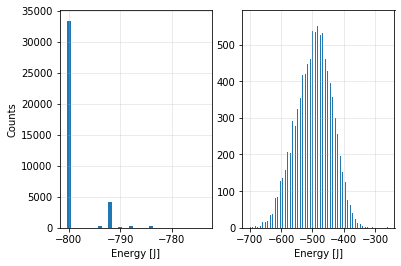

In [199]:
EnergyValue1, EnergyCount1 = ArrayElementCounter(EnergyAll20[0,SkipCycles20:-1])
EnergyValue2, EnergyCount2 = ArrayElementCounter(EnergyAll20[1,SkipCycles20:-1])
fig20Counter = plt.subplot(1,2,1)
fig20Counter.bar(EnergyValue1,EnergyCount1)
fig20Counter.grid(alpha=0.3)
fig20Counter.set_xlabel("Energy [J]")
fig20Counter.set_ylabel("Counts")
#plt.yscale("log")
fig20Counter2 = plt.subplot(1,2,2)
fig20Counter2.bar(EnergyValue2,EnergyCount2)
fig20Counter2.grid(alpha=0.3)
fig20Counter2.set_xlabel("Energy [J]")
#fig20Counter2.set_ylabel("Counts")

## Large scale run:

In [255]:
#Trial of Parallized MC
#Assigning Temperature
a = np.arange(0.20,2,0.35)
b = np.arange(2.0,2.35,0.025)
c = np.concatenate((a,b),axis=0)
d = np.arange(2.35,4.8,0.35)
TempRange = np.concatenate((c,d),axis=0)
#TempRange = np.arange(2,2.34,0.02)
print(TempRange)
#Creating Lattice
L = 8
MCCycles = int(1e4)
SkipCycles = int(0.5e4)
StateP = StateInitalize(L)
#TempRange = np.arange(0.2,3.5,0.1)
#print(TempRange)
Time = time.time()
start = time.time()
AcceptedMovesP, EnergyPerPartP, AverageMagnP, AverageMagnAbsP, SpecificHeatP, SusceptibilityP, EnergyAll, AbsMagnAll = MonteCarloIsingParallel2(StateP,MCCycles,L,TempRange,Time,SkipCycles)
end = time.time()
print("The measurement took, in seconds:", end-start)

[0.2   0.55  0.9   1.25  1.6   1.95  2.    2.025 2.05  2.075 2.1   2.125
 2.15  2.175 2.2   2.225 2.25  2.275 2.3   2.325 2.35  2.35  2.7   3.05
 3.4   3.75  4.1   4.45 ]
The measurement took, in seconds: 3.2661046981811523


In [256]:
#Write to file
filename = "RunL4No1Test.txt"
WriteToFile(filename,MCCycles,SkipCycles,L,EnergyPerPartP,SpecificHeatP,AverageMagnAbsP,SusceptibilityP,AcceptedMovesP,TempRange,end-start,EnergyAll,AbsMagnAll)

## L = 40

In [ ]:
#Assigning Temperature
a = np.arange(0.20,2,0.35)
b = np.arange(2.0,2.35,0.025)
c = np.concatenate((a,b),axis=0)
d = np.arange(2.35,4.8,0.35)
TempRange = np.concatenate((c,d),axis=0)
#TempRange = np.arange(2,2.34,0.02)
print(TempRange)
#Creating Lattice
L = 40
MCCycles = int(5e4)
SkipCycles = int(2e4)
StateP = StateInitalize(L)
#TempRange = np.arange(0.2,3.5,0.1)
#print(TempRange)
Time = time.time()
start = time.time()
AcceptedMovesP, EnergyPerPartP, AverageMagnP, AverageMagnAbsP, SpecificHeatP, SusceptibilityP, EnergyAll, AbsMagnAll = MonteCarloIsingParallel2(StateP,MCCycles,L,TempRange,Time,SkipCycles)
end = time.time()
print("The measurement took, in seconds:", end-start)
#Write to file
filename = "RunL40_Long1.txt"
WriteToFile(filename,MCCycles,SkipCycles,L,EnergyPerPartP,SpecificHeatP,AverageMagnAbsP,SusceptibilityP,AcceptedMovesP,TempRange,end-start,EnergyAll,AbsMagnAll)

## L = 60

In [ ]:
#Assigning Temperature
a = np.arange(0.20,2,0.35)
b = np.arange(2.0,2.35,0.025)
c = np.concatenate((a,b),axis=0)
d = np.arange(2.35,4.8,0.35)
TempRange = np.concatenate((c,d),axis=0)
#TempRange = np.arange(2,2.34,0.02)
print(TempRange)
#Creating Lattice
L = 40
MCCycles = int(5e4)
SkipCycles = int(2e4)
StateP = StateInitalize(L)
#TempRange = np.arange(0.2,3.5,0.1)
#print(TempRange)
Time = time.time()
start = time.time()
AcceptedMovesP, EnergyPerPartP, AverageMagnP, AverageMagnAbsP, SpecificHeatP, SusceptibilityP, EnergyAll, AbsMagnAll = MonteCarloIsingParallel2(StateP,MCCycles,L,TempRange,Time,SkipCycles)
end = time.time()
print("The measurement took, in seconds:", end-start)
#Write to file
filename = "RunL60_Long1.txt"
WriteToFile(filename,MCCycles,SkipCycles,L,EnergyPerPartP,SpecificHeatP,AverageMagnAbsP,SusceptibilityP,AcceptedMovesP,TempRange,end-start,EnergyAll,AbsMagnAll)

## L = 80

In [ ]:
#Assigning Temperature
a = np.arange(0.20,2,0.35)
b = np.arange(2.0,2.35,0.025)
c = np.concatenate((a,b),axis=0)
d = np.arange(2.35,4.8,0.35)
TempRange = np.concatenate((c,d),axis=0)
#TempRange = np.arange(2,2.34,0.02)
print(TempRange)
#Creating Lattice
L = 80
MCCycles = int(7e4)
SkipCycles = int(3e4)
StateP = StateInitalize(L)
#TempRange = np.arange(0.2,3.5,0.1)
#print(TempRange)
Time = time.time()
start = time.time()
AcceptedMovesP, EnergyPerPartP, AverageMagnP, AverageMagnAbsP, SpecificHeatP, SusceptibilityP, EnergyAll, AbsMagnAll = MonteCarloIsingParallel2(StateP,MCCycles,L,TempRange,Time,SkipCycles)
end = time.time()
print("The measurement took, in seconds:", end-start)
#Write to file
filename = "RunL80_Long1.txt"
WriteToFile(filename,MCCycles,SkipCycles,L,EnergyPerPartP,SpecificHeatP,AverageMagnAbsP,SusceptibilityP,AcceptedMovesP,TempRange,end-start,EnergyAll,AbsMagnAll)

**Plotting the relevant Parameters:**

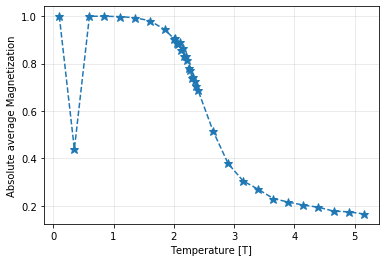

In [235]:
fig7, ax7 = plt.subplots()
ax7.plot(TempRange,AverageMagnAbsP,'*--',ms=9)
ax7.set_ylabel("Absolute average Magnetization")
ax7.set_xlabel("Temperature [T]")
ax7.grid(alpha=0.3)

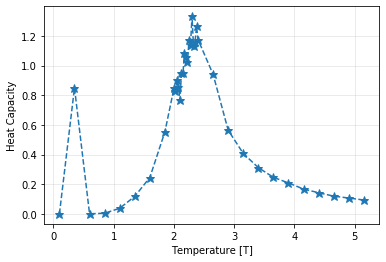

In [236]:
#Heat capacity
fig8, ax8 = plt.subplots()
ax8.plot(TempRange,SpecificHeatP,'*--',ms=9)
ax8.set_ylabel("Heat Capacity")
ax8.set_xlabel("Temperature [T]")
ax8.grid(alpha=0.3)

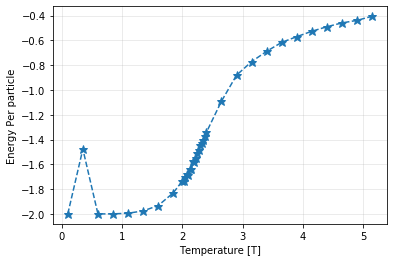

In [237]:
#Energy per Particle
fig9, ax9 = plt.subplots()
ax9.plot(TempRange,EnergyPerPartP,'*--',ms=9)
ax9.set_ylabel("Energy Per particle")
ax9.set_xlabel("Temperature [T]")
ax9.grid(alpha=0.3)

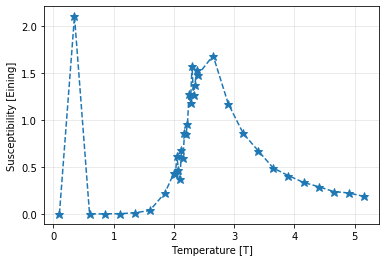

In [238]:
#Susceptibility
fig10, ax10 = plt.subplots()
ax10.plot(TempRange,SusceptibilityP,'*--',ms=9)
ax10.set_ylabel("Susceptibility [Eining]")
ax10.set_xlabel("Temperature [T]")
ax10.grid(alpha=0.3)

**Writing to file:**

In [216]:
filename = "RunL4No1Test.txt"
WriteToFile(filename,MCCycles,SkipCycles,L,EnergyPerPartP,SpecificHeatP,AverageMagnAbsP,SusceptibilityP,AcceptedMovesP,TempRange,end-start,EnergyAll)

**Plotting individual runs:**

[    0     1     2 ... 99997 99998 99999]
4.499792875


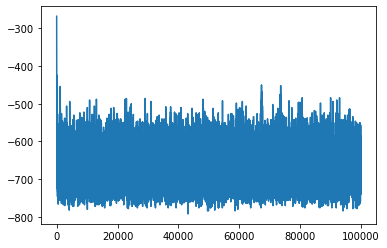

In [76]:
fig11,ax11 = plt.subplots()
Steps = np.arange(0,100000,1)
print(Steps)
ax11.plot(Steps,EnergyAll[10,:])
print(sum(EnergyAll[0,:])/((MCCycles-SkipCycles)*L**2))

## Functions not used:

In [ ]:
@jit(nopython=True,parallel=True)
def MonteCarloIsingParallel(InitialState1,NumOfCycles,LatticeSize,Temperature,Time):
    EnergyVector = np.zeros(NumOfCycles-80001)
    MagnetizationVector = np.zeros(NumOfCycles-80001)
    MagnetizationVectorAbs = np.zeros(NumOfCycles-80001)
    M = LatticeSize
    NSpins = M*M#Number of spins
    InitialState = InitialState1#Setting a lattice for overwriting
    #Calculating the initial energy
    Energy = LatticeEnergyIsing(EnergyMatrix,M)
    #print(Energy)
    MC = NumOfCycles
    SkipCycles = 80001#Number of cycles to skip for the system to reach its most likely state
    CounterAcceptance = np.zeros(len(Temperature))#Counter to see how many moves are accepted
    EnergyValue = np.zeros(len(Temperature))
    EnergyValueSquared = np.zeros(len(Temperature))
    MagnValue = np.zeros(len(Temperature))
    MagnValueSquared = np.zeros(len(Temperature))
    MagnValueAbs = np.zeros(len(Temperature))
    norm = 1/MC
    #Parallelization
    counter = np.zeros(len(Temperature))
    T = Temperature
    
    InitialStates = np.array([[np.zeros((L,L))]])#Assigning array of the same state for each vector to work on
    InitialStates[:] = InitialState
    for j in prange(len(Temperature)):
        np.random.seed(Time*(j+1))#Seeding differently for each thread if they start at the same time
        tempTemp = T[j]
        for i in range(MC):#Looping over the number of MC cycles
            #picking a random coordinate in the lattice
            randNum = np.random.randint(M*M)
            line = int(np.floor(randNum/M))#finding the relavant line in the lattice
            column = int(randNum - M*line)#finding the relavant column in the lattice
            #print(randNum,line,column)
            #flipping the spin at that position
            TempState = InitialStates[j][0].copy()
            #print(InitialState[line,column])
            #print(InitialState)
            if InitialState[line,column] == 1:
                TempState[line,column] = int(-1)
                tempValue = int(-1)#setting temp value to the assign to the system if move is accepted
            else:
                TempState[line,column] = int(1)
                tempValue = int(1)#setting temp value to the assign to the system if move is accepted
            #finding the difference in energy - using periodic boundary conditions
            DeltaE = NeigbourInteraction(line,column,TempState,M)
            if DeltaE not in [-8,-4,0,4,8]:
                print("vúpps")
            Acceptance = Metropolis(DeltaE,tempTemp)
            #Metropolis part
            if Acceptance:
                InitialStates[j][0][line,column] = tempValue
                CounterAcceptance[j] += 1  
            #Appending Energy and other relevant variables for calculations
            Energy = LatticeEnergyIsing(InitialStates[j][0],M)#Þarf að taka alltaf gildin á orkunni!!!
            if i > 80000:#Accounting for time that it takes to reach the most likely state
                #EnergyVector[counter] = Energy
                EnergyValue[j] += Energy
                EnergyValueSquared[j] += Energy**2
                #Magnetization
                MagnetiZ = Magnetization(InitialStates[j][0])
                #MagnetizationVector[counter] = MagnetiZ
                MagnValue[j] += MagnetiZ
                MagnValueSquared[j] += MagnetiZ**2
                MagnValueAbs[j] += np.absolute(MagnetiZ)
                counter[j] += 1
            #End of MC loop

    #print(InitialState)
    MC = MC - SkipCycles
    #print(Energy)
    #FinalEnergy = LatticeEnergyIsing(InitialState,M)
    #Calculating average energy per particle
    #TotalEnergy = sum(EnergyVector)
    AverageEnergy = EnergyValue/MC
    AverageEnergySquared = EnergyValueSquared/MC
    #Energy per spin
    EnergyPerParticle = AverageEnergy/NSpins
    #Magnetization
    AverageMagnetization = MagnValue/MC
    AverageMagnetizationPerPar = AverageMagnetization/NSpins
    AverageMagnetizationSquared = MagnValueSquared/MC
    AverageMagnetizationAbs = MagnValueAbs/MC
    AverageMagnetizationAbsPerSpin = AverageMagnetizationAbs/NSpins
    #Calculating the rest
    EnergyVariancePerSpin = np.zeros(len(T))
    #SpecificHeat = np.zeros(len(T))
    MagnetizationVariancePerSpin = np.zeros(len(T))
    Susceptibility = np.zeros(len(T))
    #for i in range(len(T)):#Eitthvað flipp í gangi hér!!
    #Variance in Energy
    EnergyVariancePerSpin = (AverageEnergySquared - AverageEnergy**2)/NSpins
    #Variance in Magnetization
    MagnetizationVariancePerSpin = (AverageMagnetizationSquared - AverageMagnetization**2)/(NSpins)
    #Specific Heat - SPURNING hvað ég að nota fyrir Boltzmanns fasta
    k = 1
    SpecificHeat = (1/(k*(T**2)))*EnergyVariancePerSpin
    #Susceptibility
    Susceptibility = (1/(k*T))*MagnetizationVariancePerSpin

    return CounterAcceptance, EnergyVector, EnergyPerParticle, AverageMagnetizationPerPar, AverageMagnetizationAbsPerSpin, SpecificHeat, Susceptibility